Source:

This code is written by Himanshu Rawlani

Github:
https://github.com/himanshurawlani/convnet-interpretability-keras/blob/master/Visualizing%20using%20deconvnets/deconvnet_keras.ipynb

## Visualizing CNNs using deconvolutions 

A deconvnet can be thought of as a convnet model that uses the same components (filtering, pooling) but in reverse, so instead of mapping pixels to features does the opposite. In (Zeiler et al., 2011), deconvnets were proposed as a way of performing unsupervised learning. Here, they are not used in any learning capacity, just as a probe of an already trained convnet. To examine a convnet, a deconvnet is attached to each of its layers providing a continuous path back to image pixels. 

To start, an input image is presented to the convnet and features computed throughout the layers. To examine a given convnet activation, we set all other activations in the layer to zero and pass the feature maps as input to the attached deconvnet layer. Then we successively (i) unpool, (ii) rectify and (iii) filter to reconstruct the activity in the layer beneath that gave rise to the chosen activation. This is then repeated until input pixel space is reached.

Read more: https://arxiv.org/abs/1311.2901 (Visualizing and Understanding Convolutional Networks)

In [15]:
import argparse
import numpy as np
import sys
import time
from PIL import Image
from keras.layers import (
        Input,
        InputLayer,
        Flatten,
        Activation,
        Dense)
from keras.layers.convolutional import (
        Convolution2D,
        MaxPooling2D)
from keras.activations import *
from keras.models import Model
import keras.backend as K


class DInput(object):
    '''
    A class to define forward and backward operation on Input
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Input layer, whose configuration 
                   will be used to initiate DInput(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
    
    # input and output of Input layer are the same
    def up(self, data):
        '''
        function to operate input in forward pass, the input and output
        are the same
        # Arguments
            data: Data to be operated in forward pass
        # Returns
            data
        '''
        self.up_data = data
        return self.up_data
    
    def down(self, data):
        '''
        function to operate input in backward pass, the input and output
        are the same
        # Arguments
            data: Data to be operated in backward pass
        # Returns
            data
        '''
        self.down_data = data
        return self.down_data

class DConvolution2D(object):
    '''
    A class to define forward and backward operation on Convolution2D
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Convolution2D layer, whose configuration 
                   will be used to initiate DConvolution2D(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer

        
        weights = layer.get_weights()
        W, b = weights
        config = layer.get_config()

        # Set up_func for DConvolution2D
        input = Input(shape = layer.input_shape[1:])
        output = Convolution2D.from_config(config)(input)
        up_func = Model(input, output)
        up_func.layers[1].set_weights(weights)
        self.up_func = up_func
        
        # Flip W horizontally and vertically, 
        # and set down_func for DConvolution2D
        W = np.transpose(W, (0, 1, 3, 2))
        W = W[::-1, ::-1, :, :]
        config['filters'] = W.shape[3]
        config['kernel_size'] = (W.shape[0], W.shape[1])
        b = np.zeros(config['filters'])
        input = Input(shape = layer.output_shape[1:])
        output = Convolution2D.from_config(config)(input)
        down_func = Model(input, output)
        down_func.layers[1].set_weights((W, b))
        self.down_func = down_func
        
    def up(self, data):
        '''
        function to compute Convolution output in forward pass
        # Arguments
            data: Data to be operated in forward pass
        # Returns
            Convolved result
        '''
        self.up_data = self.up_func.predict(data)
        return self.up_data

    def down(self, data):
        '''
        function to compute Deconvolution output in backward pass
        # Arguments
            data: Data to be operated in backward pass
        # Returns
            Deconvolved result
        '''
        self.down_data= self.down_func.predict(data)
        return self.down_data

class DPooling(object):
    '''
    A class to define forward and backward operation on Pooling
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Pooling layer, whose configuration 
                   will be used to initiate DPooling(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
        self.poolsize = layer.pool_size
    
    def up(self, data):
        '''
        function to compute pooling output in forward pass
        # Arguments
            data: Data to be operated in forward pass
        # Returns
            Pooled result
        '''
        [self.up_data, self.switch] = \
                self.__max_pooling_with_switch(data, self.poolsize)
        return self.up_data

    def down(self, data):
        '''
        function to compute unpooling output in backward pass
        # Arguments
            data: Data to be operated in forward pass
        # Returns
            Unpooled result
        '''
        self.down_data = self.__max_unpooling_with_switch(data, self.switch)
        return self.down_data
    
    def __max_pooling_with_switch(self, input, poolsize):
        '''
        Compute pooling output and switch in forward pass, switch stores 
        location of the maximum value in each poolsize * poolsize block
        # Arguments
            input: data to be pooled
            poolsize: size of pooling operation
        # Returns
            Pooled result and Switch
        '''
        switch = np.zeros(input.shape)
        out_shape = list(input.shape)
        row_poolsize = int(poolsize[0])
        col_poolsize = int(poolsize[1])
        out_shape[1] = out_shape[1] // poolsize[0]
        out_shape[2] = out_shape[2] // poolsize[1]
        pooled = np.zeros(out_shape)
        
        for sample in range(input.shape[0]):
            for dim in range(input.shape[3]):
                for row in range(out_shape[1]):
                    for col in range(out_shape[2]):
                        patch = input[sample, 
                                row * row_poolsize : (row + 1) * row_poolsize,
                                col * col_poolsize : (col + 1) * col_poolsize,
                                dim]
                        max_value = patch.max()
                        pooled[sample, row, col, dim] = max_value
                        max_col_index = patch.argmax(axis = -1)
                        max_cols = patch.max(axis = -1)
                        max_row = max_cols.argmax()
                        max_col = max_col_index[max_row]
                        switch[sample, 
                                row * row_poolsize + max_row, 
                                col * col_poolsize + max_col,
                              dim]  = 1
        return [pooled, switch]
    
    # Compute unpooled output using pooled data and switch
    def __max_unpooling_with_switch(self, input, switch):
        '''
        Compute unpooled output using pooled data and switch
        # Arguments
            input: data to be pooled
            poolsize: size of pooling operation
            switch: switch storing location of each elements
        # Returns
            Unpooled result
        '''
        out_shape = switch.shape
        unpooled = np.zeros(out_shape)
        for sample in range(input.shape[0]):
            for dim in range(input.shape[3]):
                tile = np.ones((switch.shape[1] // input.shape[1], 
                    switch.shape[2] // input.shape[2]))
                out = np.kron(input[sample, :, :, dim], tile)
                unpooled[sample, :, :, dim] = out * switch[sample, :, :, dim]
        return unpooled


class DActivation(object):
    '''
    A class to define forward and backward operation on Activation
    '''
    def __init__(self, layer, linear = False):
        '''
        # Arguments
            layer: an instance of Activation layer, whose configuration 
                   will be used to initiate DActivation(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
        self.linear = linear
        self.activation = layer.activation
        input = K.placeholder(shape = layer.output_shape)

        output = self.activation(input)
        # According to the original paper, 
        # In forward pass and backward pass, do the same activation(relu)
        self.up_func = K.function(
                [input, K.learning_phase()], [output])
        self.down_func = K.function(
                [input, K.learning_phase()], [output])

    # Compute activation in forward pass
    def up(self, data, learning_phase = 0):
        '''
        function to compute activation in forward pass
        # Arguments
            data: Data to be operated in forward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Activation
        '''
        self.up_data = self.up_func([data, learning_phase])[0]
        return self.up_data

    # Compute activation in backward pass
    def down(self, data, learning_phase = 0):
        '''
        function to compute activation in backward pass
        # Arguments
            data: Data to be operated in backward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Activation
        '''
        self.down_data = self.down_func([data, learning_phase])[0]
        return self.down_data
    
class DDense(object):
    '''
    A class to define forward and backward operation on Dense
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Dense layer, whose configuration 
                   will be used to initiate DDense(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
        weights = layer.get_weights()
        W, b = weights
        config = layer.get_config()
        
        #Set up_func for DDense
        input = Input(shape = layer.input_shape[1:])
        output = Dense.from_config(config)(input)
        up_func = Model(input, output)
        up_func.set_weights(weights)
        self.up_func = up_func
        
        #Transpose W and set down_func for DDense
        W = W.transpose()
        self.input_shape = layer.input_shape
        self.output_shape = layer.output_shape
        b = np.zeros(self.input_shape[1])
        flipped_weights = [W, b]
        input = Input(shape = self.output_shape[1:])
        output = Dense(units = self.input_shape[1])(input)
        down_func = Model(input, output)
        down_func.set_weights(flipped_weights)
        self.down_func = down_func
    

    def up(self, data):
        '''
        function to compute dense output in forward pass
        # Arguments
            data: Data to be operated in forward pass
        # Returns
            Result of dense layer
        '''
        self.up_data = self.up_func.predict(data)
        return self.up_data
        
    def down(self, data):
        '''
        function to compute dense output in backward pass
        # Arguments
            data: Data to be operated in forward pass
        # Returns
            Result of reverse dense layer
        '''
        # data = data - self.bias
        self.down_data = self.down_func.predict(data)
        return self.down_data
    
class DFlatten(object):
    '''
    A class to define forward and backward operation on Flatten
    '''
    def __init__(self, layer):
        '''
        # Arguments
            layer: an instance of Flatten layer, whose configuration 
                   will be used to initiate DFlatten(input_shape, 
                   output_shape, weights)
        '''
        self.layer = layer
        self.shape = layer.input_shape[1:]
        self.up_func = K.function(
                [layer.input, K.learning_phase()], [layer.output])

    # Flatten 2D input into 1D output
    def up(self, data, learning_phase = 0):
        '''
        function to flatten input in forward pass
        # Arguments
            data: Data to be operated in forward pass
            learning_phase: learning_phase of Keras, 1 or 0
        # Returns
            Flattened data
        '''
        self.up_data = self.up_func([data, learning_phase])[0]
        return self.up_data

    # Reshape 1D input into 2D output
    def down(self, data):
        '''
        function to unflatten input in backward pass
        # Arguments
            data: Data to be operated in backward pass
        # Returns
            Recovered data
        '''
        new_shape = [data.shape[0]] + list(self.shape)
        assert np.prod(self.shape) == np.prod(data.shape[1:])
        self.down_data = np.reshape(data, new_shape)
        return self.down_data


In [16]:
def find_top_filters(output, top=4):
    filter_sum = []
    print(output.shape[-1])
    for filter_index in range(output.shape[-1]):
        if output.ndim == 2:
            sum_value = np.sum(output[:, filter_index])
        else:
            sum_value = np.sum(output[:, :, :, filter_index])
        if sum_value > 0:
            filter_sum.append((filter_index, sum_value))
    filter_sum.sort(key=lambda x: x[1], reverse=True)
    return filter_sum[:top]

def visualize_all_layers(model, data, layer_name='predictions', visualize_mode='all'):
    '''
    function to visualize feature
    # Arguments
        model: Pre-trained model used to visualize data
        data: image to visualize
        layer_name: Name of layer to visualize
        feature_to_visualize: Features to visualize
        visualize_mode: Visualize mode, 'all' or 'max', 'max' will only pick 
                        the greates activation in a feature map and set others
                        to 0s, this will indicate which part fire the neuron 
                        most; 'all' will use all values in a feature map,
                        which will show what image the filter sees. For 
                        convolutional layers, There is difference between 
                        'all' and 'max', for Dense layer, they are the same
    # Returns
        The image reflecting feature
    '''
    deconv_layers = []
    # Stack layers
    for layer in model.layers:
        if isinstance(layer, Convolution2D):
            deconv_layers.append((layer.name, DConvolution2D(layer)))
            deconv_layers.append((layer.name + '_activation', DActivation(layer)))
        elif isinstance(layer, MaxPooling2D):
            deconv_layers.append((layer.name, DPooling(layer)))
        elif isinstance(layer, Dense):
            deconv_layers.append((layer.name, DDense(layer)))
            deconv_layers.append((layer.name + '_activation', DActivation(layer)))
        elif isinstance(layer, Activation):
            deconv_layers.append((layer.name, DActivation(layer)))
        elif isinstance(layer, Flatten):
            deconv_layers.append((layer.name, DFlatten(layer)))
        elif isinstance(layer, InputLayer):
            deconv_layers.append((layer.name, DInput(layer)))
        else:
            print('Cannot handle this type of layer')
            print(layer.get_config())
            sys.exit()
        if layer_name == layer.name:
            break

    # Forward pass
    deconv_layers[0][1].up(data)
    for i in range(1, len(deconv_layers)):
        deconv_layers[i][1].up(deconv_layers[i - 1][1].up_data)
        
    # Selecting layers to visualize
    layers_to_visualize = []
    model_layers = set([layer.name for layer in model.layers])
    layers_to_visualize = [x for x, y in enumerate(deconv_layers) 
                           if y[0] in model_layers]
    layers_to_visualize.reverse()
    # Removing the input layer
    layers_to_visualize.pop()
    print('layers_to_visualize:', layers_to_visualize)
    
    deconv_dict = dict()
    for i in layers_to_visualize:
        deconv_list = []
        output = deconv_layers[i][1].up_data
        top_filters = find_top_filters(output)
        print('output.shape :', output.shape)
        print('deconv_layer:', deconv_layers[i][0])
        print('top_filters:', top_filters)
        for feature_to_visualize, sum_value in top_filters:
            assert output.ndim == 2 or output.ndim == 4
            if output.ndim == 2:
                feature_map = output[:, feature_to_visualize]
            else:
                feature_map = output[:, :, :, feature_to_visualize]
            if 'max' == visualize_mode:
                max_activation = feature_map.max()
                temp = feature_map == max_activation
                feature_map = feature_map * temp
            elif 'all' != visualize_mode:
                print('Illegal visualize mode')
                sys.exit()
            output_temp = np.zeros_like(output)
            if 2 == output.ndim:
                output_temp[:, feature_to_visualize] = feature_map
            else:
                output_temp[:, :, :, feature_to_visualize] = feature_map

            # Backward pass
            deconv_layers[i][1].down(output_temp)
            for j in range(i - 1, -1, -1):
                deconv_layers[j][1].down(deconv_layers[j + 1][1].down_data)
            deconv = deconv_layers[0][1].down_data
            deconv = deconv.squeeze()
            deconv_list.append(deconv)
        deconv_dict[deconv_layers[i][0]] = deconv_list
    
    return deconv_dict

### Load the model

In [17]:
from IPython.display import display, HTML
from keras.utils import plot_model

def plot_model_architecture(base_model, model_name):
    plot_model(base_model, show_shapes=True, to_file=model_name)
    display(HTML('<img src="{}" style="display:inline;margin:1px"/>'.format(model_name)))

In [18]:
from keras.preprocessing import image
from keras.applications import vgg16
import keras.backend as K
K.set_image_data_format('channels_last')

model = vgg16.VGG16(weights = 'imagenet', include_top = True)
#plot_model_architecture(model, 'vgg16_channel_last.svg')

In [19]:
for layer in model.layers:
    print(layer.name, layer)

input_34 <keras.engine.input_layer.InputLayer object at 0x0000028FEF870DC8>
block1_conv1 <keras.layers.convolutional.Conv2D object at 0x0000028FEFD3B2C8>
block1_conv2 <keras.layers.convolutional.Conv2D object at 0x0000028FF4E078C8>
block1_pool <keras.layers.pooling.MaxPooling2D object at 0x0000028FEF8703C8>
block2_conv1 <keras.layers.convolutional.Conv2D object at 0x0000028FF5FDE708>
block2_conv2 <keras.layers.convolutional.Conv2D object at 0x0000028FED4F0C48>
block2_pool <keras.layers.pooling.MaxPooling2D object at 0x0000028FF5FC6848>
block3_conv1 <keras.layers.convolutional.Conv2D object at 0x0000028FBBA87A88>
block3_conv2 <keras.layers.convolutional.Conv2D object at 0x0000028FCA7A4208>
block3_conv3 <keras.layers.convolutional.Conv2D object at 0x0000028FF5D3AA08>
block3_pool <keras.layers.pooling.MaxPooling2D object at 0x0000028FF5D9A648>
block4_conv1 <keras.layers.convolutional.Conv2D object at 0x0000028FF5C48288>
block4_conv2 <keras.layers.convolutional.Conv2D object at 0x0000028FE

### Perform forward pass and deconvs

In [24]:
from keras.applications.vgg16 import preprocess_input
in_array = np.expand_dims(image.img_to_array(
           image.load_img('barber_chair.jpg', target_size=(224, 224))), axis=0)
img_array = preprocess_input(in_array)

In [25]:
deconv = visualize_all_layers(model, img_array)

layers_to_visualize: [37, 35, 33, 32, 31, 29, 27, 25, 24, 22, 20, 18, 17, 15, 13, 11, 10, 8, 6, 5, 3, 1]
1000
output.shape : (1, 1000)
deconv_layer: predictions
top_filters: [(423, 0.9863587), (424, 0.012866885), (606, 0.00047979428), (827, 0.0001085218)]
4096
output.shape : (1, 4096)
deconv_layer: fc2
top_filters: [(1734, 13.072748), (2918, 11.418976), (3584, 11.142699), (201, 10.919856)]
4096
output.shape : (1, 4096)
deconv_layer: fc1
top_filters: [(1263, 59.700077), (2446, 40.605293), (3380, 37.07614), (2009, 35.548115)]
25088
output.shape : (1, 25088)
deconv_layer: flatten
top_filters: [(16001, 249.93217), (15926, 221.17), (19585, 219.86903), (8332, 211.73471)]
512
output.shape : (1, 7, 7, 512)
deconv_layer: block5_pool
top_filters: [(129, 1915.6366255283356), (140, 1702.6813898086548), (99, 1576.263036698103), (489, 1432.5334663391113)]
512
output.shape : (1, 14, 14, 512)
deconv_layer: block5_conv3
top_filters: [(129, 5027.4004), (140, 4691.5083), (99, 4065.7207), (489, 3505.6099)

In [26]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Visualizing input

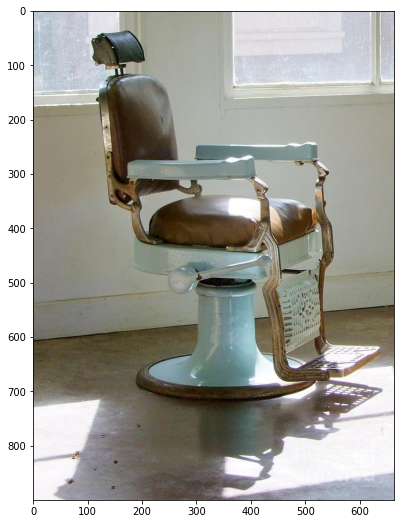

In [27]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
%matplotlib inline

plt.figure(figsize=(9, 9))
plt.imshow(image.img_to_array(image.load_img('barber_chair.jpg')) / 255.)

### Visualizing output

`deconv` is a dictionary of lists with layer names as keys and the input pixel space of the top 4 filters as its list elements.

In [28]:
for key in deconv.keys():
    print(key)

predictions
fc2
fc1
flatten
block5_pool
block5_conv3
block5_conv2
block5_conv1
block4_pool
block4_conv3
block4_conv2
block4_conv1
block3_pool
block3_conv3
block3_conv2
block3_conv1
block2_pool
block2_conv2
block2_conv1
block1_pool
block1_conv2
block1_conv1


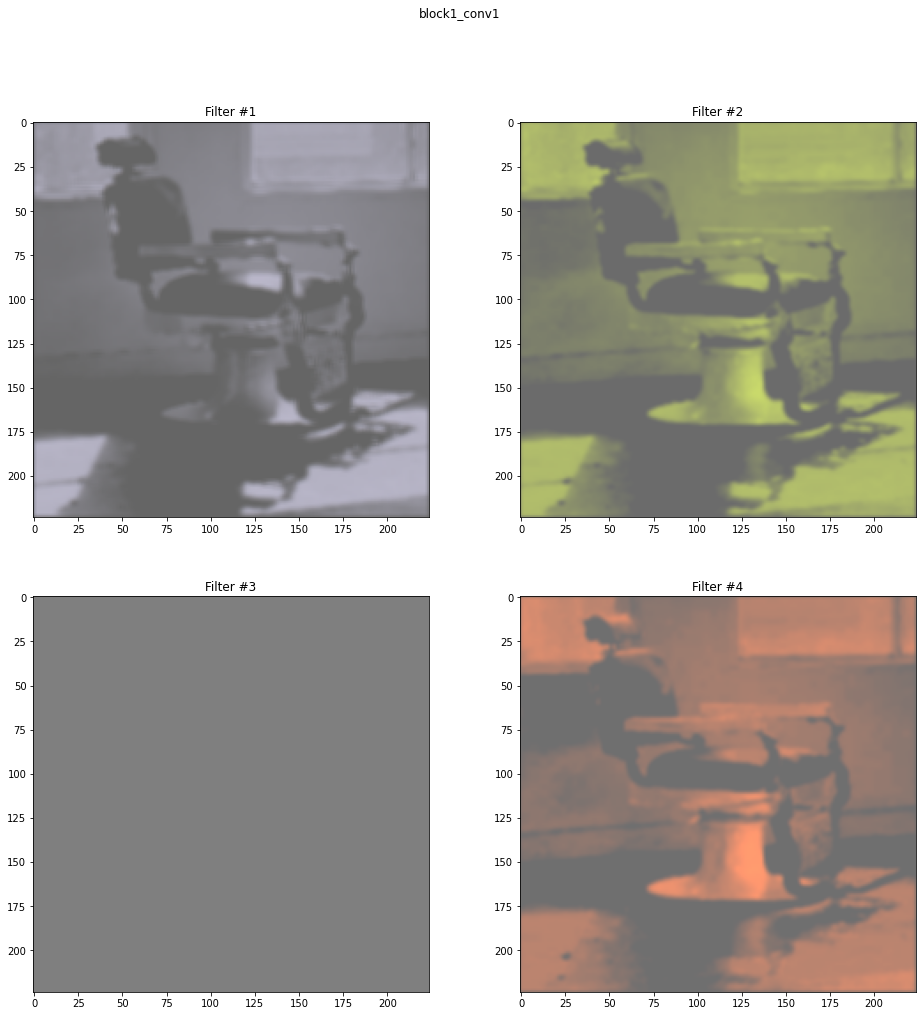

In [29]:
plt.figure(figsize=(16, 16))
layer_name = 'block1_conv1'
plt.suptitle(layer_name)

for i, img in enumerate(deconv[layer_name]):
    plt.subplot(2,2,i+1)
    plt.imshow(deprocess_image(img))
    # Use the below commented line for block1 visualizations
    # Since, deprocess_image() is not required for block1 visualizations
    # plt.imshow(img)
    plt.title('Filter #{}'.format(i+1))

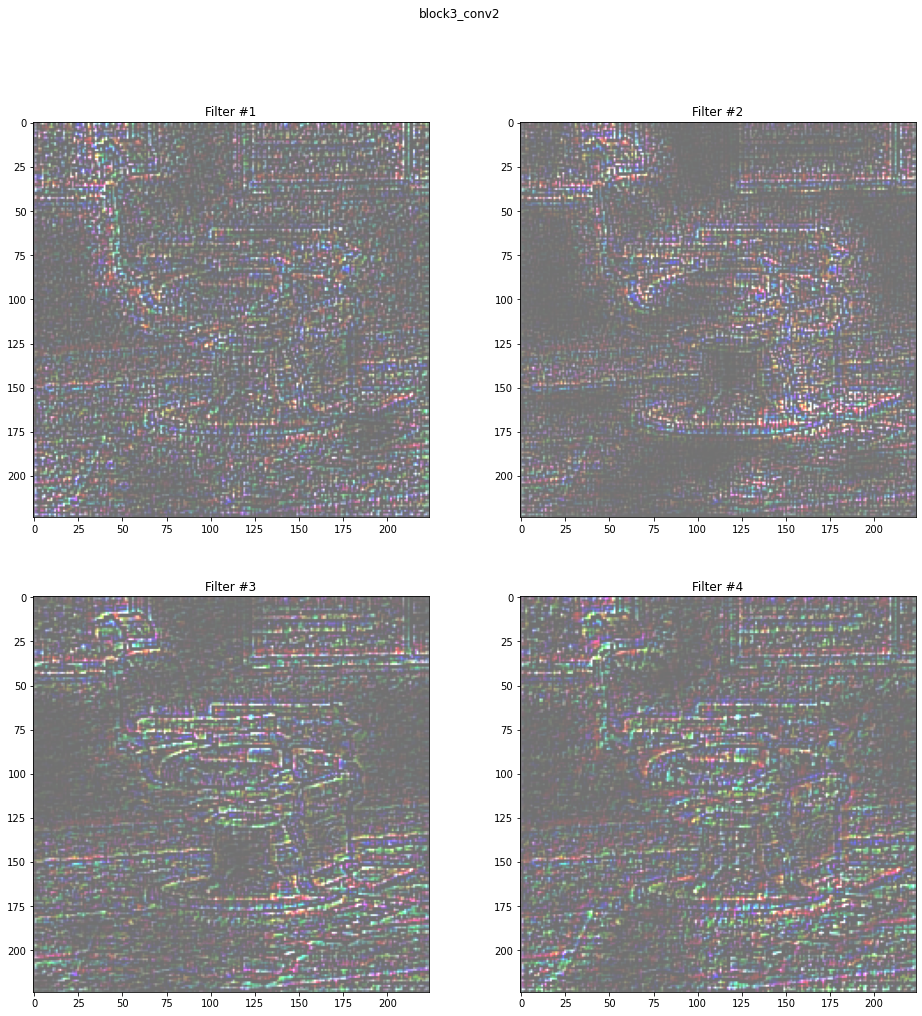

In [30]:
plt.figure(figsize=(16, 16))
layer_name = 'block3_conv2'
plt.suptitle(layer_name)

for i, img in enumerate(deconv[layer_name]):
    plt.subplot(2,2,i+1)
    plt.imshow(deprocess_image(img))
    # Use the below commented line for block1 visualizations
    # Since, deprocess_image() is not required for block1 visualizations
    # plt.imshow(img)
    plt.title('Filter #{}'.format(i+1))

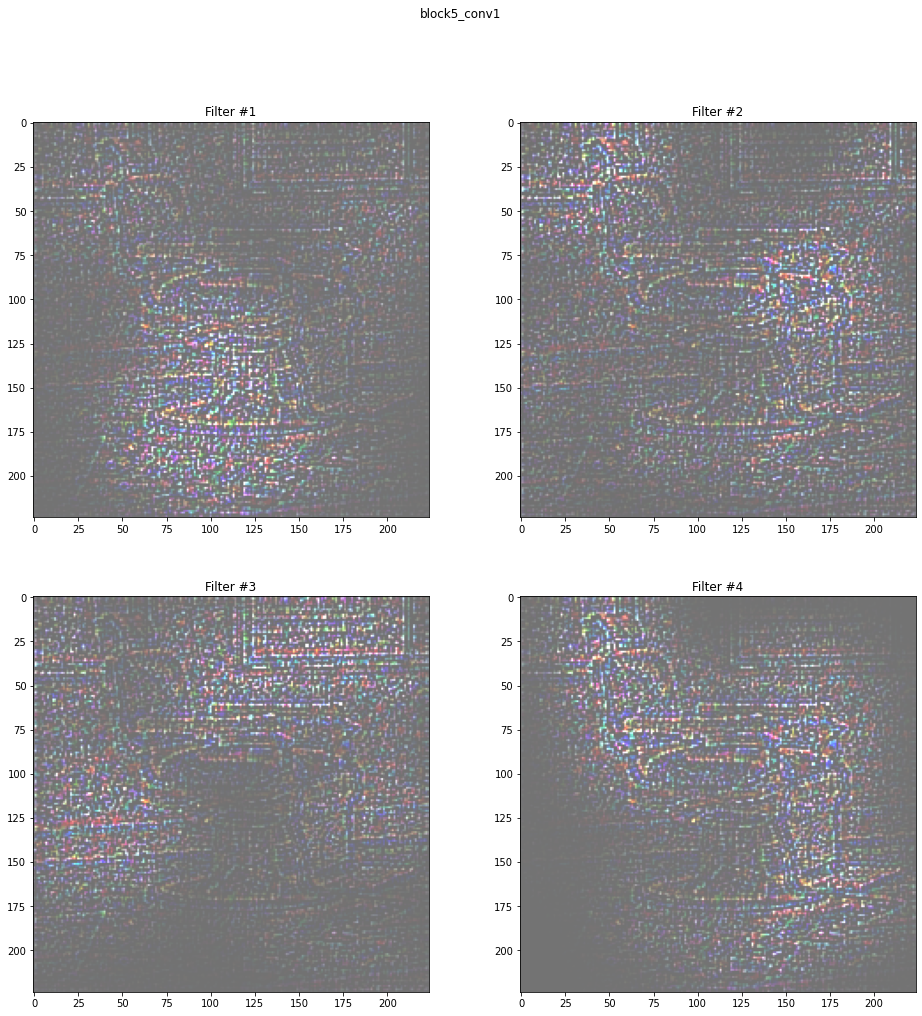

In [31]:
plt.figure(figsize=(16, 16))
layer_name = 'block5_conv1'
plt.suptitle(layer_name)

for i, img in enumerate(deconv[layer_name]):
    plt.subplot(2,2,i+1)
    plt.imshow(deprocess_image(img))
    # Use the below commented line for block1 visualizations
    # Since, deprocess_image() is not required for block1 visualizations
    # plt.imshow(img)
    plt.title('Filter #{}'.format(i+1))

Projecting the feature activations back to the input space gives us similar insights as to what the filters in those layers were activated upon. We see some of the projections having prominent horizontal edges and some having prominent vertical edges. Some of the projections cover eyes, nose, mouth and some cover entire face. Projecting each of the top activations separately down to pixel space reveals the different structures, in the input image, that excite a given feature map.

In [32]:
from keras.applications.vgg16 import decode_predictions
decode_predictions(model.predict(img_array))

[[('n02791124', 'barber_chair', 0.9863587),
  ('n02791270', 'barbershop', 0.012866885),
  ('n03584829', 'iron', 0.00047979428),
  ('n04330267', 'stove', 0.0001085218),
  ('n04141975', 'scale', 5.3419077e-05)]]